In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy, deepcopy 

#Pacejka 5.2 (2002) pure logitudinal with IA

params_Indy=[1.603,     #PCY1 Shape factor Cfy for lateral forces
            1.654,      #PDY1 Lateral friction Muy
            -0.1783,    #PDY2 Variation of friction Muy with load
            0.0,        #PDY3 Variation of friction Muy with squared camber
            -1.409,     #PEY1 Lateral curvature Efy at Fznom
            -1.6617,    #PEY2 Variation of curvature Efy with load
            0.26886,    #PEY3 Zero order camber dependency of curvature Efy
            -13.61,     #PEY4 Variation of curvature Efy with camber
            -53.05,     #PKY1 Maximum value of stiffness Kfy/Fznom
            4.1265,     #PKY2 Load at which Kfy reaches maximum value
            1.5016,     #PKY3 Variation of Kfy/Fznom with camber
            0.0039,     #PHY1 Horizontal shift Shy at Fznom
            -0.00253,   #PHY2 Variation of shift Shy with load
            0.0,        #PHY3 Variation of shift Shy with camber
            -0.01038,   #PVY1 Vertical shift in Svy/Fz at Fznom
            -0.1,       #PVY2 Variation of shift Svy/Fz with load
            0.4498,     #PVY3 Variation of shift Svy/Fz with camber
            -1.5,       #PVY4 Variation of shift Svy/Fz with camber and load
            35.304,     #RBY1 lope factor for combined Fy reduction
            15.666,     #RBY2 Variation of slope Fy reduction with alpha
            -0.01179,   #RBY3 Shift term for alpha in slope Fy reduction
            1.018,      #PCY1 Shape factor for combined Fy reduction
            0.35475,    #REY1 Curvature factor of combined Fy
            0.01966,    #REY2 Curvature factor of combined Fy with load
            0.00667,    #RHY1 Shift factor for combined Fy reduction
            0.00207,    #RHY2Shift factor for combined Fy reduction with load
            0.0426,     #RVY1 Kappa induced side force Svyk/Muy*Fz at Fznom
            0.03077,    #RVY2 Variation of Svyk/Muy*Fz with load
            0.37305,    #RVY3 Variation of Svyk/Muy*Fz with camber
            100.0,      #RVY4 Variation of Svyk/Muy*Fz with alpha
            2.2,        #RVY5 Variation of Svyk/Muy*Fz with kappa
            25.0,       #RVY6 Variation of Svyk/Muy*Fz with atan(kappa)
            0.0,        #PTY1 Peak value of relaxation length SigAlp0/R0
            0.0]        #PTY2 Value of Fz/Fznom where SigAlp0 is extreme


params_PKW=[1.5,        #PCY1 Shape factor Cfy for lateral forces
            1.2,        #PDY1 Lateral friction Muy
            -0.09,      #PDY2 Variation of friction Muy with load
            0.1,        #PDY3 Variation of friction Muy with squared camber
            0.1,        #PEY1 Lateral curvature Efy at Fznom
            -1.2,       #PEY2 Variation of curvature Efy with load
            0.05,       #PEY3 Zero order camber dependency of curvature Efy
            -8.1,       #PEY4 Variation of curvature Efy with camber
            -75.5,      #PKY1 Maximum value of stiffness Kfy/Fznom
            4.65,       #PKY2 Load at which Kfy reaches maximum value
            -0.6,       #PKY3 Variation of Kfy/Fznom with camber
            0.003,      #PHY1 Horizontal shift Shy at Fznom
            -0.0006,    #PHY2 Variation of shift Shy with load
            0.004,      #PHY3 Variation of shift Shy with camber
            -0.04,      #PVY1 Vertical shift in Svy/Fz at Fznom
            -0.02,      #PVY2 Variation of shift Svy/Fz with load
            -0.97,      #PVY3 Variation of shift Svy/Fz with camber
            -0.41,      #PVY4 Variation of shift Svy/Fz with camber and load
            20.6,       #RBY1 lope factor for combined Fy reduction
            -23.5,      #RBY2 Variation of slope Fy reduction with alpha
            0.001,      #RBY3 Shift term for alpha in slope Fy reduction
            1.0,        #PCY1 Shape factor for combined Fy reduction
            0.0,        #REY1 Curvature factor of combined Fy
            0.0,        #REY2 Curvature factor of combined Fy with load
            -0.02,      #RHY1 Shift factor for combined Fy reduction
            0.0,        #RHY2Shift factor for combined Fy reduction with load
            0.16,       #RVY1 Kappa induced side force Svyk/Muy*Fz at Fznom
            0.03,       #RVY2 Variation of Svyk/Muy*Fz with load
            27.5,       #RVY3 Variation of Svyk/Muy*Fz with camber
            -29.7,      #RVY4 Variation of Svyk/Muy*Fz with alpha
            0.03,       #RVY5 Variation of Svyk/Muy*Fz with kappa
            0.0,        #RVY6 Variation of Svyk/Muy*Fz with atan(kappa)
            3.8,        #PTY1 Peak value of relaxation length SigAlp0/R0
            4.7]        #PTY2 Value of Fz/Fznom where SigAlp0 is extreme             

Fz=18000 #N Fz range von Indy 8000-18000 N

i=5000
alpha=np.linspace(-0.3,0.3,i)
IA=1
Fz0=16000 #nominal load (z.b 80% von Fzmax)
PKY4 = -2 #usally 2 (Pacejka Buch)
    
    
def Pacejka5_2(Fz,alpha,IA,Fz0,params): 
    #IA=inclination angle,  Fz0= highest load in data, 
    
    #converts to rad
    gamma = IA*np.pi/180
    
    dfz = ((Fz-Fz0)/Fz0)  
    Shy = (params[11] + params[12] * dfz)
    alphay = alpha + Shy
    Kya = params[8] * Fz * np.sin(PKY4 * np.arctan(Fz/((params[9]) * Fz)))/(1 + params[10] * gamma**2)   #skalingFaktor Fz = 1 
    C = params_Indy[0] 
    mu = (params[1] + params[2] * dfz) / (1 + params[3] * gamma**2)
    D = mu*Fz
    B = Kya / (C * D + 0.001)  #e=0.001
    E = (params[4] + params[5] * dfz ) * (1 - (params[6] + params[7] * gamma) * np.sign(alphay)) 
    
    
    Svyg = Fz * (params[16] + params[17] * dfz)
    Svy = Fz * (params[14] * params[15] * dfz)
   
    
    Fy= D * np.sin(C * np.arctan(B * alphay - E * (B*alphay - np.arctan(B * alphay)))) + Svy
    
    return Fy,D,B,C,Kya

#print(Pacejka5_2(4000,alpha,IA,Fz0,params_Indy)[4])
#plt.plot(alpha,Pacejka5_2(Fz,alpha,IA,Fz0,params_PKW)[0])

In [2]:
#Vergleichsgrößen

def Fy_intervall(Fz,Fy_intv,params,IA): #Fz in [kN], Fx_intv in % (z.b 10% von Fx_max)
#x Position von Fx_max berechnene
    Fy_w=Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]
    w=len(Fy_w)
    Fy_max_pos=0
    for j in range(0,w):
        if Fy_w[j] == np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]):
            break
        else:
            Fy_max_pos = Fy_max_pos + 1

    #cut slop
    cut = int(w/2)
    Fy_w_pos = Fy_w[cut::]
    Fy_w_pos_max=Fy_w_pos[0:((Fy_max_pos-cut)+1)] #von 0 bis Fx_max
    Fy_w_max_end=Fy_w_pos[((Fy_max_pos-cut)+1)::] #von Fx_max bis Ende(+100% slipratio)

    Fy_max_ref = np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]) * Fy_intv #Referenzwert Fx 10% weniger als Fx_max

    left=0
    j=0
    for j in range(0,len(Fy_w_pos_max)):
        if Fy_w_pos_max[j] < Fy_max_ref:
            left +=1
        else:
            break
        
    right = 0
    j=0
    for j in range(0,len(Fy_w_max_end)):
        if Fy_w_max_end[j] > Fy_max_ref:
            right +=1
        else:
            break
        
#Intervall 10% abweichung von Fx_max = [left,right]
    Fy_max_10=Fy_w[cut+left:cut+len(Fy_w_pos_max)+right]
    Fy_slope_b=((len(Fy_w_pos_max)+right)-left)/(cut/100) #breite des Intervalls in %Schlupf
    
    return Fy_slope_b,Fy_max_10,cut,left,right,Fy_w_pos_max


steps=11
Fz_arr1=np.linspace(8000,18000,steps) #von 1kN bis 10kN Fz
Fz_arr=np.round(Fz_arr1,5)

Fy_max_arr = np.zeros((steps,))
Start_slope = np.zeros((steps,))
Dy_max = np.zeros((steps,))
Fy_intv_arr = np.zeros((steps,))
Fy_max_slip_arr = np.zeros((steps,))

plt.figure
i=0

for i in range(1,steps):
    #plt.plot(SL,Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[0],label="Fz={}N".format(Fz_arr[i]))
    #plt.legend(loc = "upper left")
    
    Fy_max_arr[i] = np.max(Pacejka5_2(Fz_arr[int(i)],alpha,IA,Fz0,params_Indy)[0]) #numerischer Maximalert
    Fy_max_slip_arr[i] = np.argmax(Pacejka5_2(Fz_arr[int(i)],alpha,IA,Fz0,params_Indy)[0]) #slipwert bei Fx_max
    Start_slope[i] = np.arctan(Pacejka5_2(Fz_arr[int(i)],alpha,IA,Fz0,params_Indy)[1] * 
                               Pacejka5_2(Fz_arr[int(i)],alpha,IA,Fz0,params_Indy)[2] * 
                               Pacejka5_2(Fz_arr[int(i)],alpha,IA,Fz0,params_Indy)[3]) #Anfangssteigung
    Dy_max[i] = Pacejka5_2(Fz_arr[int(i)],alpha,IA,Fz0,params_Indy)[1] #maximalWert aus Modell
    Fy_intv_arr[i] = Fy_intervall(Fz_arr[i],0.9,params_Indy,IA)[0] #Intervall mit >= 90%Fx_max


#Schräglaufsteifigkeit

def slope(Fz,params,IA):
    slope = np.arctan(Pacejka5_2(Fz,alpha,IA,Fz0,params)[1] * 
                               Pacejka5_2(Fz,alpha,IA,Fz0,params)[2] * 
                               Pacejka5_2(Fz,alpha,IA,Fz0,params)[3])
    return slope
    

In [3]:
#größen für lokale SA

s = 0.1 #10% änderung
params_SA = deepcopy(params_Indy)
Fz = 10000 #[N]

Text(0.5, 1.0, 'lokale SA Fy_max, Parameter -10% ')

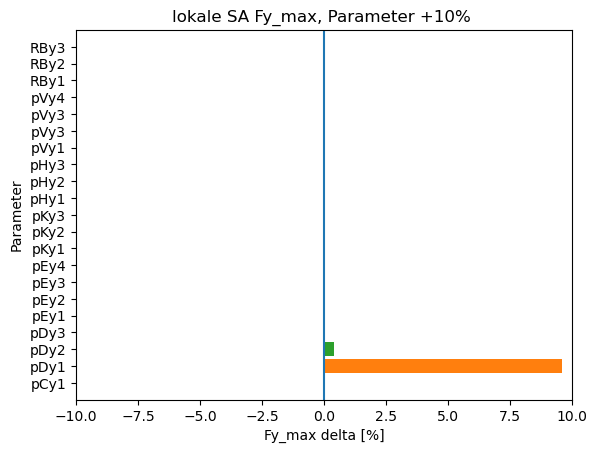

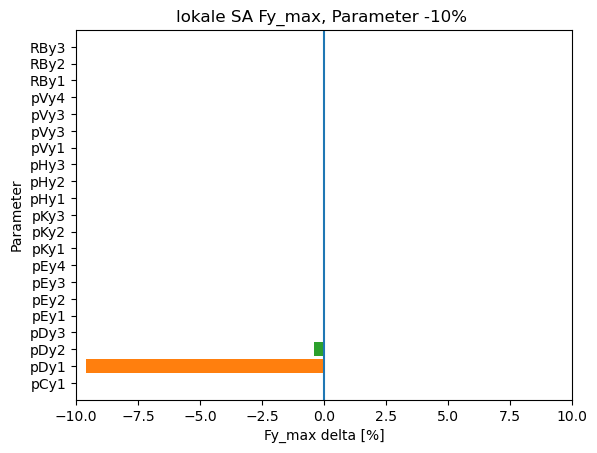

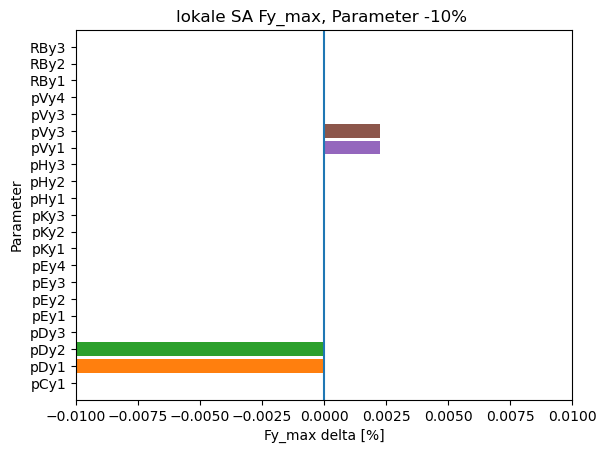

In [12]:
### lokale Sensitivität

#Fx_max#Fz = 4000N, IA = 0.1°
i=0
pramas_Set=params_SA
params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_Fx_max_pos = (np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]) - np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_pos)[0]))/np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0])
    params_pos[i] = params[i]
    
    params_neg[i] = params_neg[i]*(1-s)
    delta_Fx_max_neg = (np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]) - np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_neg)[0]))/np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-10,10)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fy_max, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-10,10)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fy_max, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.01,0.01)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fy_max, Parameter -10% ')


Text(0.5, 1.0, 'lokale SA,alpha bei Fy_max, Parameter +10% ')

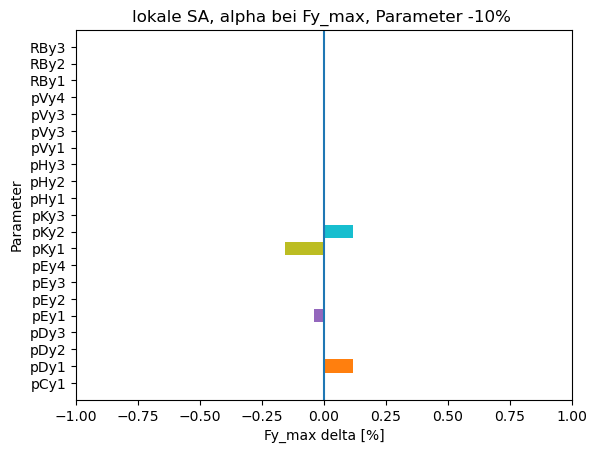

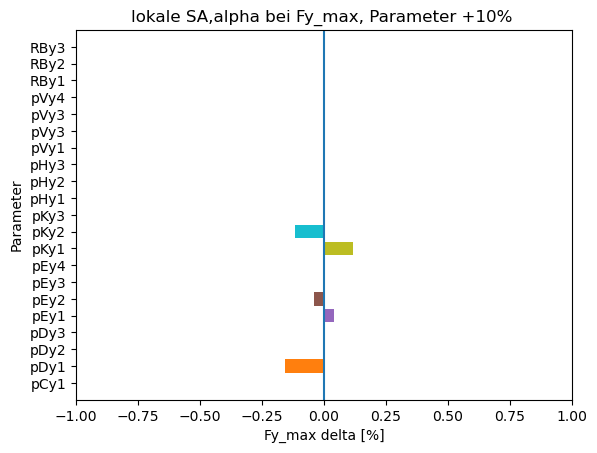

In [6]:
#alpha bei max Fy

#Fy_max#Fz = 4000N, IA = 0.1°
i=0
pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]) - np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_pos)[0]))/(np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]))
    params_pos[i] = params[i]
   
    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]) - np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_neg)[0]))/(np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params)[0]))
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-1,1)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, alpha bei Fy_max, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-1,1)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA,alpha bei Fy_max, Parameter +10% ')

Text(0.5, 1.0, 'lokale SA, alpha Intervall (10% von Fy max), Parameter +10% ')

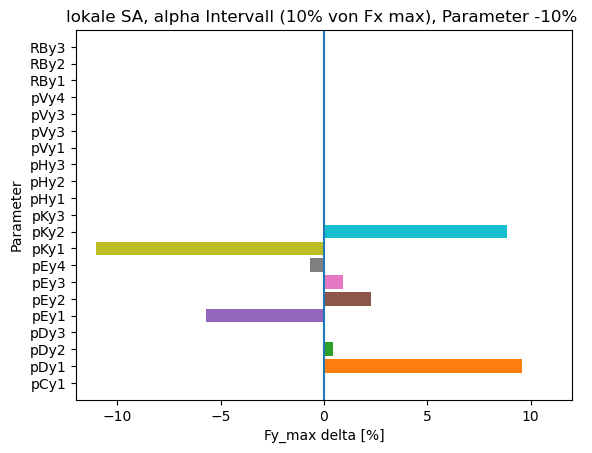

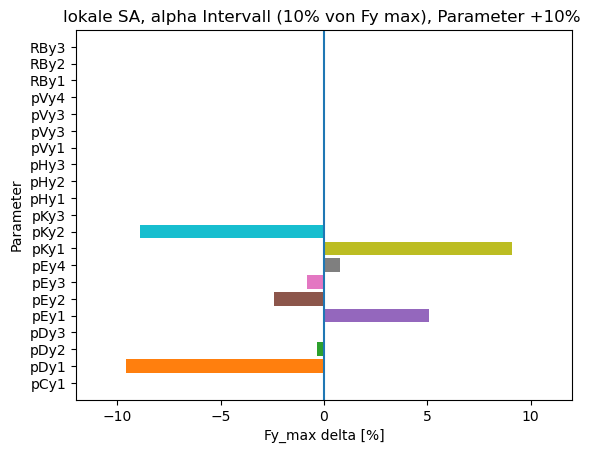

In [13]:
#alpha Intervall (10% von Fx max)

#Fy_max, IA = 0.1°
i=0


pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = deepcopy(pramas_Set)
params_neg = deepcopy(pramas_Set)
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (Fy_intervall(Fz,0.9,params,IA)[0] - Fy_intervall(Fz,0.9,params_pos,IA)[0])/(Fy_intervall(Fz,0.9,params,IA)[0])
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (Fy_intervall(Fz,0.9,params,IA)[0] - Fy_intervall(Fz,0.9,params_neg,IA)[0])/(Fy_intervall(Fz,0.9,params,IA)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-12,12)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, alpha Intervall (10% von Fx max), Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-12,12)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, alpha Intervall (10% von Fy max), Parameter +10% ')

1.570788091476467


Text(0.5, 1.0, 'lokale SA, Fz (10% von Fz ref), Parameter +10% ')

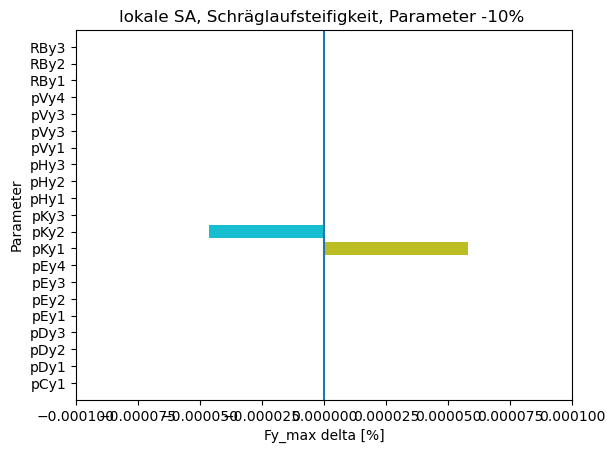

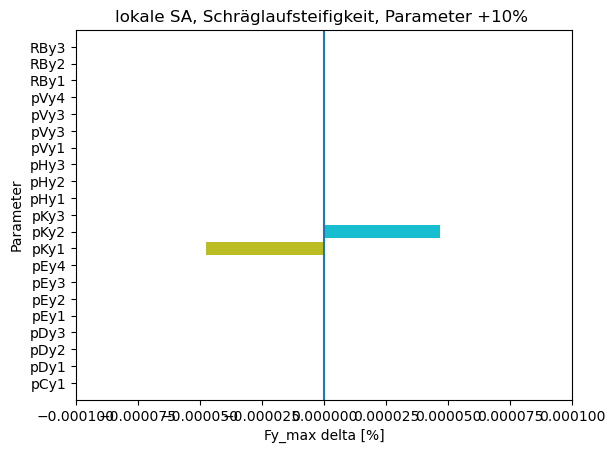

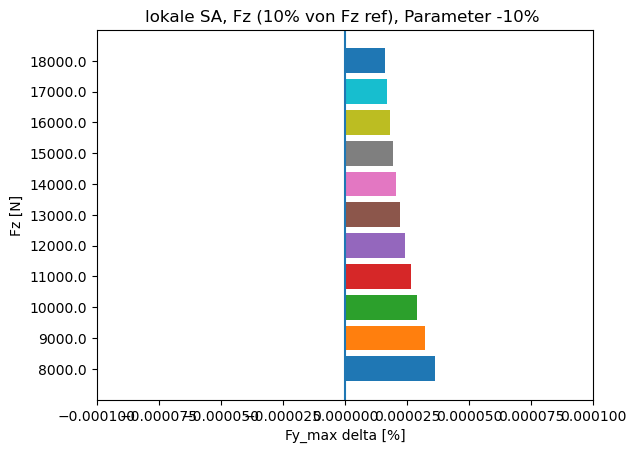

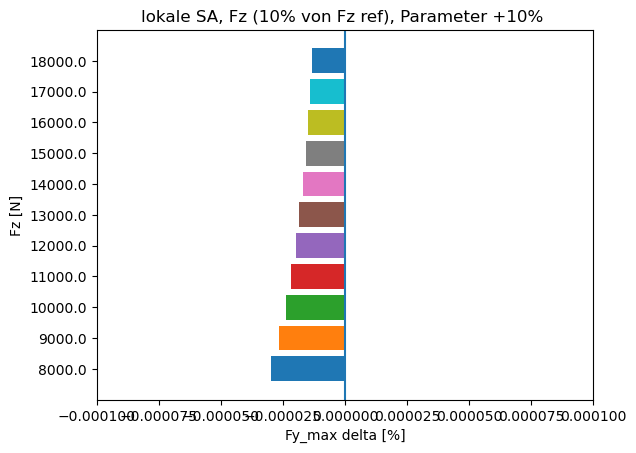

In [14]:
#Schräglaufsteifigkeit 

#Fy_max#Fz = 4000N, IA = 0.1°
i=0
IA =0
pramas_Set=params_SA
Fz = 5000

params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

a=slope(5000,params_Indy,IA)
print(a)
for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (slope(Fz,params,0) - slope(Fz,params_pos,0))/(slope(Fz,params,0))
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (slope(Fz,params,0) - slope(Fz,params_neg,0))/(slope(Fz,params,0))
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0



#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.0001,0.0001)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Schräglaufsteifigkeit, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCy1', 'pDy1', 'pDy2','pDy3', 'pEy1', 'pEy2', 'pEy3', 'pEy4', 'pKy1', 'pKy2','pKy3', 'pHy1', 'pHy2','pHy3', 'pVy1', 'pVy3', 'pVy3', 'pVy4', 'RBy1', 'RBy2', 'RBy3')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.0001,0.0001)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Schräglaufsteifigkeit, Parameter +10% ')

#--> Schräglaufsteifigkeit sehr wenig von einzelnen parametern abhängig
#Vorzeichen überprüfen !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Lokale SA Schräglaufsteifigkeit Fz, abhängig

Fz_arr = np.linspace(8000,18000,11)
Fz_arr_pos = deepcopy(Fz_arr)
Fz_arr_neg = deepcopy(Fz_arr)
delta=np.zeros((len(Fz_arr),2))
delta_neg = 0
delta_pos = 0

i=0
for i in range(0,len(Fz_arr)):
    
    Fz_arr_pos[i] = Fz_arr[i]*(1+s)
    delta_pos = (slope(Fz_arr[i],params_Indy,IA) - slope(Fz_arr_pos[i],params_Indy,IA))/(slope(Fz_arr[i],params_Indy,IA))
    Fz_arr_pos[i] = Fz_arr[i]
    

    Fz_arr_neg[i] = Fz_arr[i]*(1-s)
    delta_neg = (slope(Fz_arr[i],params_Indy,IA) - slope(Fz_arr_neg[i],params_Indy,IA))/(slope(Fz_arr[i],params_Indy,IA))
    Fz_arr_neg[i] = Fz_arr[i]
    
        
    delta[i] = [delta_neg*100, delta_pos*100]

i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fz_arr)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(Fz_arr)):
    delta_neg[i,1] = 0



#Plots params -10%
fig, ax = plt.subplots()
y_axis=Fz_arr
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.0001,0.0001)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Fz [N]")
plt.title('lokale SA, Fz (10% von Fz ref), Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=Fz_arr
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.0001,0.0001)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Fz [N]")
plt.title('lokale SA, Fz (10% von Fz ref), Parameter +10% ')

[[ 0.00000000e+00  0.00000000e+00]
 [-2.60010400e-02  5.20020801e-02]
 [ 5.73723465e-02 -1.00000000e+02]
 [-5.69555415e-08  6.29508698e-08]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.20020801e-02]
 [ 0.00000000e+00 -1.00000000e+02]
 [ 0.00000000e+00  6.29508698e-08]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.20020801e-02]
 [ 0.00000000e+00 -1.00000000e+02]
 [ 0.00000000e+00  6.29508698e-08]]


Text(0.5, 1.0, 'lokale SA, IA (10% von IA ref), Parameter +10% ')

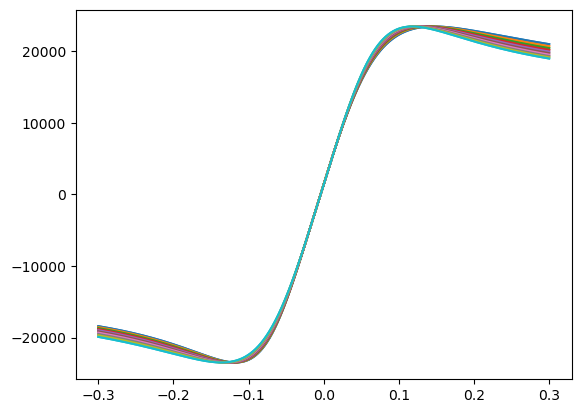

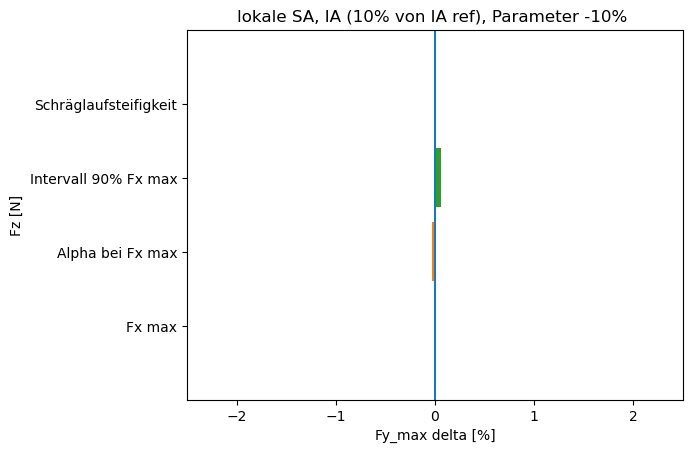

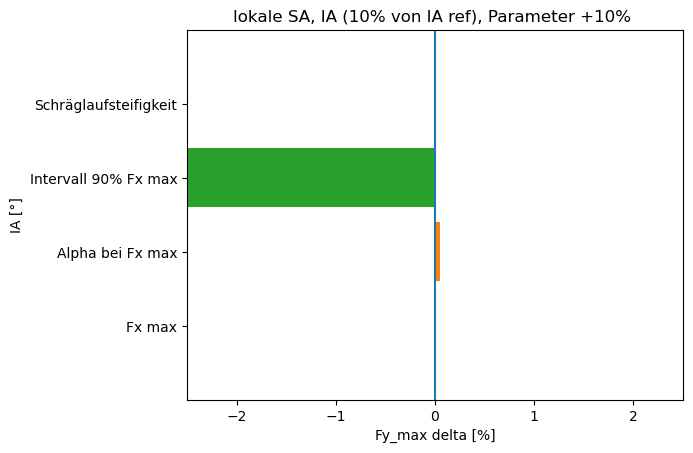

In [5]:
#Sturzabhängigkeit auf Fy Max

IA = np.linspace(-2,2,10)

i=0
Fz=4000
plt.figure
#x=np.zeros((,len(IA)))
for i in range(0,len(IA)):
    plt.plot(alpha,Pacejka5_2(14000,alpha,IA[i],Fz0,params_Indy)[0])
    
   # x[i]=Pacejka5_2(4000,SL,IA[i],Fz0,params_Indy)[0]

x=(Pacejka5_2(4000,alpha,IA[0],Fz0,params_PKW)[0]-Pacejka5_2(4000,alpha,IA[1],Fz0,params_PKW)[0])[0]
#print(x)
#print(IA*np.pi/180)

plt.figure
i=0
for i in range(0,len(IA)):
    plt.plot(alpha,Pacejka5_2(14000,alpha,IA[i],Fz0,params_Indy)[0])

    
    
IA = 1 #Referenzwert


    
IA_pos = deepcopy(IA)
IA_neg = deepcopy(IA)
i=0

delta=np.zeros((4,2))

#Fx_max
IA_pos = IA_pos*(1+s)
delta_Fx_max_pos = (np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.max(Pacejka5_2(Fz,alpha,IA_pos,Fz0,params_SA)[0]))/np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0])
IA_pos = IA
    
IA_neg = IA_neg*(1-s)
delta_Fx_max_neg = (np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.max(Pacejka5_2(Fz,alpha,IA_neg,Fz0,params_SA)[0]))/np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0])
IA_neg = IA
    


#alpha bei Fx_max
i=1
IA_pos = IA_pos*(1+s)
delta_pos = (np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.argmax(Pacejka5_2(Fz,alpha,IA_pos,Fz0,params_SA)[0]))/(np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]))
IA_pos = IA
   
IA_neg = IA_neg*(1-s)
delta_neg = (np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.argmax(Pacejka5_2(Fz,alpha,IA_neg,Fz0,params_SA)[0]))/(np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]))
IA_neg = IA
    
delta[1] = [delta_neg*100, delta_pos*100]

#Intervall
i=2
IA_pos = IA_pos*(1+s)
delta_pos = (Fy_intervall(Fz,2,params_SA,IA)[0] - Fy_intervall(Fz,0.9,params_SA,IA_pos)[0])/(Fy_intervall(Fz,0.9,params_SA,IA)[0])
IA_pos = IA

IA_neg = IA_neg*(1-s)
delta_neg = (Fy_intervall(Fz,0.9,params_SA,IA)[0] - Fy_intervall(Fz,0.9,params_SA,IA_neg)[0])/(Fy_intervall(Fz,0.9,params_SA,IA)[0])
IA_neg = IA
    
delta[2] = [delta_neg*100, delta_pos*100]

#Schräglaufsteifigkeit
i=3
IA_pos = IA_pos*(1+s)
delta_pos = (slope(Fz,params_SA,IA) - slope(Fz,params_SA,IA_pos))/(slope(Fz,params_SA,IA))
IA_pos = IA

IA_neg = IA_neg*(1-s)
delta_neg = (slope(Fz,params_SA,IA) - slope(Fz,params_SA,IA_neg))/(slope(Fz,params_SA,IA))
IA_neg = IA
    
delta[3] = [delta_neg*100, delta_pos*100]

print(delta)
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,4):
    delta_pos[i,0] = 0

i=0
for i in range(0,4):
    delta_neg[i,1] = 0

print(delta_pos)
print(delta_pos)
#Plots params -10%
fig, ax = plt.subplots()
y_axis=('Fx max', 'Alpha bei Fx max', 'Intervall 90% Fx max', 'Schräglaufsteifigkeit')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-2.5,2.5)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Fz [N]")
plt.title('lokale SA, IA (10% von IA ref), Parameter -10% ')


#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('Fx max', 'Alpha bei Fx max', 'Intervall 90% Fx max', 'Schräglaufsteifigkeit')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-2.5,2.5)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("IA [°]")
plt.title('lokale SA, IA (10% von IA ref), Parameter +10% ')

In [7]:
a=slope(5000,params_Indy,0)
print(a)

1.570788091476467
